In [1]:
import numpy as np

# Load data
with np.load("c4_mnist-6k.npz", allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'labels': array([5, 0, 4, ..., 8, 6, 9])}

The dictionary contains a data entry with the pixel values of the 6,000 images and a labels one with their target values.

We will train our model on 5,000 train images, monitor the training process with a validation set of 500 images and use the 500 remaining ones to get a final test score.

In [3]:
from sklearn.model_selection import train_test_split

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    mnist["data"].astype(np.float32),
    mnist["labels"],
    test_size=1000,
    random_state=0,
)

# Split again into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=500, random_state=0
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (5000, 784) (5000,)
Validation: (500, 784) (500,)
Test: (500, 784) (500,)


**Softmax Network**

In [4]:
import tensorflow as tf

# Initialize network parameters
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))

This code is similar to what we saw in the previous unit. We create the two variables and set their initial values with the initial_value parameter. We create a (784,10) matrix of zeros for the weights matrix using the zeros() function from TensorFlow. Similarly, we create a (10,) vector of zeros for the biases vector.

In [5]:
# Create input/target tensors
X = tf.constant(X_train)
y = tf.constant(y_train)

In [6]:
# Compute logits
logits = tf.add(tf.matmul(X, W), b)   # b is the bias values
print(logits.shape)

(5000, 10)


In [7]:
# We can also pass the numpy matrix directly
logits = tf.add(tf.matmul(X_train, W), b)
print(logits.shape)

(5000, 10)


**Cross-entropy Loss Function**

In [8]:
# Cross-entropy loss function
y_one_hot = tf.one_hot(indices=y, depth=10)
ce = tf.nn.softmax_cross_entropy_with_logits(
    labels=y_one_hot, logits=logits  # Requires one-hot encoded labels
)
print(ce.shape)

(5000,)


The function requires the target values to be one-hot encoded. To achieve this, we add a one-hot encoding operation with the one_hot() function. We pass the target node y with the indices argument and the number of classes with the depth one. We can then create the softmax with cross-entropy node ce which contains the cross-entropy score for each data point.

Note that TensorFlow also provides a sparse_softmax_cross_entropy_with_logits() function that doesn’t require the labels to be one-hot encoded.

In [9]:
# Cross-entropy loss function (without one-hot encoding)
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
print(ce.shape)

(5000,)


In [10]:
# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)
print(mean_ce)

tf.Tensor(2.302591, shape=(), dtype=float32)


**Optimizer**

In [12]:
# Gradient descent
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

**Measuring accuracy**

To compute the accuracy of our network, let’s start by creating a predictions tensor with the class that has the maximum logit value using the argmax() function.

In [13]:
# Compute predictions
predictions = tf.argmax(
    logits,                # shape: (n, 10)
    axis=1,                # class with max logit
    output_type=tf.int32,  # Same type as labels
)
print(predictions.shape)

(5000,)


The function will return the index of the column (axis one) in the logits matrix with the largest value for each data point. Hence, we get a predictions tensor with one entry for each data point, and its shape is (5000,).

To compute the accuracy of our network, we need to compare these predictions to the target values. For this reason, the two tensors need to have the same data type. In the code from above, we set the data type of the output of the argmax() function with the output_type argument.

In [14]:
# Are the predictions correct?
is_correct = tf.equal(y, predictions)
print(is_correct.shape)

(5000,)


The is_correct variable is a tensor with a boolean value for each data point. The accuracy of our network is simply the proportion of True entries. To compute this accuracy value, we first convert the boolean values to numerical 0/1 values with the cast() function and then compute the mean with the reduce_mean() one.

In [16]:
# Accuracy
accuracy = tf.reduce_mean(
    # Convert booleans (false/true) to 0/1 float numbers
    tf.cast(is_correct, dtype=tf.float32)
)
print(accuracy.shape)

()


**Batch Generator**

Usually train neural networks with small batches of data points.

In [17]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i : i + batch_size], y[i : i + batch_size]


get_batches(X_train, y_train, 64)

<generator object get_batches at 0x00000234F61A3270>

In this code, we define a get_batches() function that returns batches of data points from the X and y arrays of size batch_size. To achieve this, we generate an index i that ranges between zero and the number of data points by steps of size batch_size. For instance, if we have 10 data points and the batch size is 3, the i variable will take the values 0, 3, 6 and 9. To create the current batch, we extract rows of the X/y arrays between i and i+batch_size. 

**Training (eager execution mode)**

In [18]:
# Accuracy score after each batch of data
acc_values = []

# Get batches of data
for X_batch, y_batch in get_batches(X_train, y_train, 64):
    # Run training operation
    with tf.GradientTape() as tape:
        logits = tf.add(tf.matmul(X_batch, W), b)
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y_batch, logits=logits
        )
        mean_ce = tf.reduce_mean(ce)
    optimizer.minimize(loss=mean_ce, var_list=[W, b], tape=tape)

    # Compute predictions
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)

    # Compute accuracy
    is_correct = tf.equal(y_batch, predictions)
    batch_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

    acc_values.append(batch_acc)

# Get weight matrix and biases
W_fitted = W.numpy()
b_fitted = b.numpy()

We run the training operation by batches of data and save the batch accuracy values in an acc_values variable. At the end, we get the weights matrix and the biases vector with the numpy() function converts TensorFlow tensors to Numpy arrays.

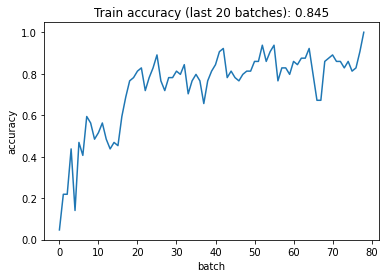

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(acc_values)
plt.title(
    "Train accuracy (last 20 batches): {:.3f}".format(
        # Average accuracy value
        np.mean(acc_values[-20:])
    )
)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.show()

Since we evaluate the accuracy on only 64 data points, our accuracy measure is not very precise and varies a lot between each batch of data. However, it’s clear that our network is learning and the final test accuracy should be between 80% and 90% if we didn’t overfit.

**Visualize templates**

We saw above that each output neuron learns from the data by tuning its synaptic weights (the columns of W). These weights are the signature of each output neuron. They tell us what each neuron tries to detect in the input. In our case, each weight corresponds to a pixel in our 28 by 28 images. Hence, we can plot these weights to get templates of digits learned by each neuron.

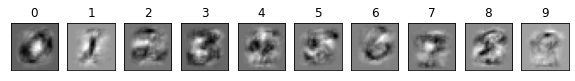

In [20]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted[:, i]

    # Reshape weight values into a 28x28 array
    template = weights.reshape(28, 28)

    # Plot array
    axis.imshow(template, plt.cm.gray_r)  # Grayscale (reversed)
    axis.get_xaxis().set_visible(False)   # disable x-axis
    axis.get_yaxis().set_visible(False)   # disable y-axis
    axis.set_title(i)                     # Adds title to image

plt.show()

In this code, we create a figure with ten subplots using the subplots() function from Pyplot and get a list of axes. We plot each template by enumerating the axes. The axis and the i variables in the for loop contain each axis and its index in the list of axes. We use the index to extract the weights of the i-th output neuron and reshape these weights into a 28 by 28 array that we can then plot by calling the imshow() function of the axis object. Note that we hide the x and y axes with the set_visible() function.

These ten templates define what each neuron expects. Black areas correspond to pixels that “stimulate” the output neuron, gray areas correspond to pixels that have a small impact on the output, and white areas correspond to pixels that decrease the activity of the neuron. For instance, the template for images of zeros will detect images (positive logit) with positive pixel values on the circle around the center of the image (black area) but reject ones (negative logit value) with positive pixel values in the center of the image (white area).

**Improve Learning**

In [21]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object and fit it to train data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [22]:
# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

# Reinitialize the network parameters to zero
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))

# Reinitialize gradient descent and decrease the learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Rescale input data
X_train_rescaled = scaler.transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)


# Get batches of data
for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
    # Run training
    with tf.GradientTape() as tape:
        train_logits = tf.add(tf.matmul(X_batch, W), b)
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y_batch, logits=train_logits
        )
        mean_ce = tf.reduce_mean(ce)
    optimizer.minimize(loss=mean_ce, var_list=[W, b], tape=tape)

    # Evaluate training accuracy
    predictions = tf.argmax(train_logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y_batch, predictions)
    train_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    train_acc_values.append(train_acc)

    # Evaluate validation accuracy
    valid_logits = tf.add(tf.matmul(X_valid_rescaled, W), b)
    valid_predictions = tf.argmax(valid_logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y_valid, valid_predictions)
    valid_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    valid_acc_values.append(valid_acc)

# Get weight matrix and biases
W_fitted = W.numpy()
b_fitted = b.numpy()

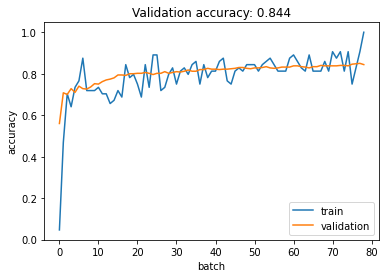

In [23]:
# Plot accuracy values
plt.plot(train_acc_values, label="train")
plt.plot(valid_acc_values, label="validation")
plt.title(
    "Validation accuracy: {:.3f}".format(
        valid_acc_values[-1]  # Last validation accuracy value
    )
)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

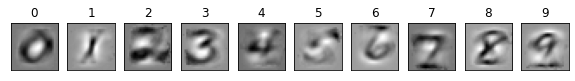

In [24]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted[:, i]

    # Reshape weight values into a 28x28 array
    template = weights.reshape(28, 28)

    # Plot array
    axis.imshow(template, plt.cm.gray_r)  # Grayscale (reversed)
    axis.get_xaxis().set_visible(False)   # disable x-axis
    axis.get_yaxis().set_visible(False)   # disable y-axis
    axis.set_title(i)                     # Adds title to image

plt.show()

In [25]:
# Evaluate validation accuracy
X_test_rescaled = scaler.transform(X_test)

test_logits = tf.add(tf.matmul(X_test_rescaled, W), b)
test_predictions = tf.argmax(test_logits, axis=1, output_type=tf.int32)

is_correct = tf.equal(y_test, test_predictions)
test_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

print("Test accuracy: {:.3f}".format(test_acc))

Test accuracy: 0.850


**Training (graph mode)**

In [26]:
# Define the optimizer (if not done yet)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [27]:
# Compute the logits
@tf.function
def compute_logits(x, W, b):
    logits = tf.add(tf.matmul(x, W), b)
    return logits


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y, W, b):
    with tf.GradientTape() as tape:
        logits = compute_logits(x, W, b)
        loss = compute_loss(y, logits)
    optimizer.minimize(loss=loss, var_list=[W, b], tape=tape)
    return logits, loss

In [28]:
# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

# Reinitialize the network parameters to zero
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))


# Get batches of data
for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
    # Run training
    train_logits, _ = train(X_batch, y_batch, W, b)

    # Evaluate training accuracy
    train_acc = compute_accuracy(y_batch, train_logits)
    train_acc_values.append(train_acc)

    # Evaluate validation accuracy
    valid_logits = compute_logits(X_valid_rescaled, W, b)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

# Get weight matrix and biases
W_fitted = W.numpy()
b_fitted = b.numpy()

Same outcome but graph mode more efficient